In [1]:
import os

from functools import reduce  # Import reduce

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MaxNLocator, FuncFormatter

from IPython.display import display
from IPython.display import clear_output
                                                                    
import seaborn as sns

import joblib

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, make_scorer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.feature_selection import SequentialFeatureSelector, VarianceThreshold
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from category_encoders import TargetEncoder

from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from scipy.stats import mode

# Кластеры для районов
# Таргет трайнуть

In [1]:
from util.test123 import check

check()

test.ipynb imported
ZVC23


In [21]:
pd.options.display.float_format = '{:.6f}'.format
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns if needed
np.set_printoptions(threshold=np.inf)  # For NumPy arrays

In [22]:
def color_cells(val):
    """ val: значение признака """

    if val == 'float64':
        color = 'red'
    elif val == 'int64':
        color = 'red'
    else:
        color = 'blue'
    return f'color: {color}'

def valeraInfo(df):
    info = pd.DataFrame()
    info.index = df.columns
    info['Тип данных'] = df.dtypes
    info['Количесвто уникальных'] = df.nunique()
    info['Количество пропусков'] = df.isna().sum()
    info['Количество значений'] = df.count()
    info['%значений'] = round((df.count()/ df.shape[0]) * 100,2)
    info = info.style.applymap(color_cells, subset=['Тип данных'])
    return info

In [23]:
folder_path = "dumps"  # Specify your folder

def dump_ZV(content, file_name, folder_path = "dumps"):
    os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist
    file_path = os.path.join(folder_path, f"{file_name}.joblib")
    joblib.dump(content, file_path)
    print(f"Saved {file_name} to {file_path}")

def undump_ZV(file_name, folder_path = "dumps"):
    file_path = os.path.join(folder_path, f"{file_name}.joblib")
    return joblib.load(file_path)

In [24]:
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, columns):
        self.transformer = transformer
        self.columns = columns

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        X_transformed = self.transformer.transform(X)
        return pd.DataFrame(X_transformed, columns=self.columns)

In [25]:
DATA_PATH = os.path.join("datasets", "Sber_housing_kaggle")
data_file = ["train.csv"]
macro_file = ["macro.csv"]

In [26]:
load_data = lambda path, files_names: (
    [pd.read_csv(os.path.join(path, file), parse_dates=["timestamp"]) for file in files_names]
)

In [27]:
[data] = load_data(DATA_PATH, data_file)
[macro ] = load_data(DATA_PATH, macro_file)

In [28]:
print(macro.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 100 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   timestamp                                   2484 non-null   datetime64[ns]
 1   oil_urals                                   2484 non-null   float64       
 2   gdp_quart                                   2394 non-null   float64       
 3   gdp_quart_growth                            2394 non-null   float64       
 4   cpi                                         2453 non-null   float64       
 5   ppi                                         2453 non-null   float64       
 6   gdp_deflator                                2119 non-null   float64       
 7   balance_trade                               2453 non-null   float64       
 8   balance_trade_growth                        2394 non-null   float64       
 9   usdrub 

In [30]:
data.head(1)

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [11]:
macro.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,eurrub,brent,net_capital_export,gdp_annual,gdp_annual_growth,average_provision_of_build_contract,average_provision_of_build_contract_moscow,rts,micex,micex_rgbi_tr,micex_cbi_tr,deposits_value,deposits_growth,deposits_rate,mortgage_value,mortgage_growth,mortgage_rate,grp,grp_growth,income_per_cap,real_dispos_income_per_cap_growth,salary,salary_growth,fixed_basket,retail_trade_turnover,retail_trade_turnover_per_cap,retail_trade_turnover_growth,labor_force,unemployment,employment,invest_fixed_capital_per_cap,invest_fixed_assets,profitable_enterpr_share,unprofitable_enterpr_share,share_own_revenues,overdue_wages_per_cap,fin_res_per_cap,marriages_per_1000_cap,divorce_rate,construction_value,invest_fixed_assets_phys,pop_natural_increase,pop_migration,pop_total_inc,childbirth,mortality,housing_fund_sqm,lodging_sqm_per_cap,water_pipes_share,baths_share,sewerage_share,gas_share,hot_water_share,electric_stove_share,heating_share,old_house_share,average_life_exp,infant_mortarity_per_1000_cap,perinatal_mort_per_1000_cap,incidence_population,rent_price_4+room_bus,rent_price_3room_bus,rent_price_2room_bus,rent_price_1room_bus,rent_price_3room_eco,rent_price_2room_eco,rent_price_1room_eco,load_of_teachers_preschool_per_teacher,child_on_acc_pre_school,load_of_teachers_school_per_teacher,students_state_oneshift,modern_education_share,old_education_build_share,provision_doctors,provision_nurse,load_on_doctors,power_clinics,hospital_beds_available_per_cap,hospital_bed_occupancy_per_year,provision_retail_space_sqm,provision_retail_space_modern_sqm,turnover_catering_per_cap,theaters_viewers_per_1000_cap,seats_theather_rfmin_per_100000_cap,museum_visitis_per_100_cap,bandwidth_sports,population_reg_sports_share,students_reg_sports_share,apartment_build,apartment_fund_sqm
0,2010-01-01,76.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.200000,-0.078209,5.000000,NaN,NaN,NaN,NaN,NaN,7484970,NaN,NaN,142968,NaN,13.720000,8375.863800,NaN,30789.200000,0.038000,38410.500000,NaN,11443.630000,2882.416900,251.484000,106.800000,6436.244000,0.018000,0.690000,63932.000000,732.760604,0.716000,0.284000,0.962915,12865.000000,233.351529,8.000000,3.900000,553874.900000,95.800000,-0.300000,14.100000,13.800000,10.700000,11.000000,216.000000,18.715883,99.900000,99.800000,99.600000,44.400000,95.700000,55.000000,99.900000,0.300000,74.200000,6.100000,5.870000,696.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.000000,99.400000,7872.848285,162.900000,NaN,NaN,NaN,690.000000,6221.000000,527.000000,0.410000,993.000000,NaN,NaN,63.030000,22825.000000,NaN
1,2010-01-02,76.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.200000,-0.078209,5.000000,NaN,NaN,NaN,NaN,175.150000,7484970,NaN,NaN,142968,NaN,13.720000,8375.863800,NaN,30789.200000,0.038000,38410.500000,NaN,11443.630000,2882.416900,251.484000,106.800000,6436.244000,0.018000,0.690000,63932.000000,732.760604,0.716000,0.284000,0.962915,12865.000000,233.351529,8.000000,3.900000,553874.900000,95.800000,-0.300000,14.100000,13.800000,10.700000,11.000000,216.000000,18.715883,99.900000,99.800000,99.600000,44.400000,95.700000,55.000000,99.900000,0.300000,74.200000,6.100000,5.870000,696.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.477765,"45,713",1356.112607,NaN,NaN,NaN,18.000000,99.400000,7872.848285,162.900000,NaN,NaN,NaN,690.000000,6221.000000,527.000000,0.410000,993.000000,NaN,NaN,63.030000,22825.000000,NaN
2,2010-01-03,76.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38807.200000,-0.078209,5.000000,NaN,NaN,NaN,NaN,178.660000,7484970,NaN,NaN,142968,NaN,13.720000,8375.863800,NaN,30789.200000,0.038000,38410.500000,NaN,11443.630000,2882.416900,251.484000,106.800000,6436.244000,0.018000,0.690000,63932.000000,732.760604,0.716000,0.284000,0.962915,12865.000000,233.351529,8.000000,3.900000,553874.900000,95.800000,-0.300000,14.100000,13.800000,10.700000,11.000000,216.000000,18.715883,

In [12]:
valeraInfo(macro)

C:\Users\Nick\AppData\Local\Temp\ipykernel_4168\3045055618.py:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  info = info.style.applymap(color_cells, subset=['Тип данных'])


,Тип данных,Количесвто уникальных,Количество пропусков,Количество значений,%значений
timestamp,datetime64[ns],2484,0,2484,100.000000
oil_urals,float64,81,0,2484,100.000000
gdp_quart,float64,26,90,2394,96.380000
gdp_quart_growth,float64,23,90,2394,96.380000
cpi,float64,78,31,2453,98.750000
ppi,float64,81,31,2453,98.750000
gdp_deflator,float64,6,365,2119,85.310000
balance_trade,float64,80,31,2453,98.750000
balance_trade_growth,float64,26,90,2394,96.380000
usdrub,float64,1754,3,2481,99.880000


In [13]:
raw_data = data
# raw_data = data.merge(macro, on="timestamp", how="left")

In [14]:
raw_data.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

In [15]:
# Code block
boolean_category_columns = [
    'culture_objects_top_25',
    'thermal_power_plant_raion',
    'incineration_raion',
    'oil_chemistry_raion',
    'radiation_raion',
    'railroad_terminal_raion',
    'big_market_raion',
    'nuclear_reactor_raion',
    'detention_facility_raion',
    'water_1line',
    'big_road1_1line',
    'railroad_1line',
]
binary_category_column = 'product_type'
multi_category_columns = [
    'sub_area',
    'ecology',
]
date_сolumn = 'timestamp'
sub_area_column = 'sub_area'
ecology_column = 'ecology'
target_column = 'price_doc'

In [16]:
features_to_remove_outliers_dynamically = [
    'green_part_500', 'prom_part_500', 'office_count_500', 'office_sqm_500',
    'trc_count_500', 'trc_sqm_500', 'cafe_count_500', 'cafe_sum_500_min_price_avg',
    'cafe_sum_500_max_price_avg', 'cafe_avg_price_500', 'cafe_count_500_na_price',
    'cafe_count_500_price_500', 'cafe_count_500_price_1000', 'cafe_count_500_price_1500',
    'cafe_count_500_price_2500', 'cafe_count_500_price_4000', 'cafe_count_500_price_high',
    'big_church_count_500', 'church_count_500', 'mosque_count_500', 'leisure_count_500',
    'sport_count_500', 'market_count_500', 'green_part_1000', 'prom_part_1000',
    'office_count_1000', 'office_sqm_1000', 'trc_count_1000', 'trc_sqm_1000',
    'cafe_count_1000', 'cafe_sum_1000_min_price_avg', 'cafe_sum_1000_max_price_avg',
    'cafe_avg_price_1000', 'cafe_count_1000_na_price', 'cafe_count_1000_price_500',
    'cafe_count_1000_price_1000', 'cafe_count_1000_price_1500', 'cafe_count_1000_price_2500',
    'cafe_count_1000_price_4000', 'cafe_count_1000_price_high', 'big_church_count_1000',
    'church_count_1000', 'mosque_count_1000', 'leisure_count_1000', 'sport_count_1000',
    'market_count_1000', 'green_part_1500', 'prom_part_1500', 'office_count_1500',
    'office_sqm_1500', 'trc_count_1500', 'trc_sqm_1500', 'cafe_count_1500',
    'cafe_sum_1500_min_price_avg', 'cafe_sum_1500_max_price_avg', 'cafe_avg_price_1500',
    'cafe_count_1500_na_price', 'cafe_count_1500_price_500', 'cafe_count_1500_price_1000',
    'cafe_count_1500_price_1500', 'cafe_count_1500_price_2500', 'cafe_count_1500_price_4000',
    'cafe_count_1500_price_high', 'big_church_count_1500', 'church_count_1500',
    'mosque_count_1500', 'leisure_count_1500', 'sport_count_1500', 'market_count_1500',
    'green_part_2000', 'prom_part_2000', 'office_count_2000', 'office_sqm_2000',
    'trc_count_2000', 'trc_sqm_2000', 'cafe_count_2000', 'cafe_sum_2000_min_price_avg',
    'cafe_sum_2000_max_price_avg', 'cafe_avg_price_2000', 'cafe_count_2000_na_price',
    'cafe_count_2000_price_500', 'cafe_count_2000_price_1000', 'cafe_count_2000_price_1500',
    'cafe_count_2000_price_2500', 'cafe_count_2000_price_4000', 'cafe_count_2000_price_high',
    'big_church_count_2000', 'church_count_2000', 'mosque_count_2000', 'leisure_count_2000',
    'sport_count_2000', 'market_count_2000', 'green_part_3000', 'prom_part_3000',
    'office_count_3000', 'office_sqm_3000', 'trc_count_3000', 'trc_sqm_3000',
    'cafe_count_3000', 'cafe_sum_3000_min_price_avg', 'cafe_sum_3000_max_price_avg',
    'cafe_avg_price_3000', 'cafe_count_3000_na_price', 'cafe_count_3000_price_500',
    'cafe_count_3000_price_1000', 'cafe_count_3000_price_1500', 'cafe_count_3000_price_2500',
    'cafe_count_3000_price_4000', 'cafe_count_3000_price_high', 'big_church_count_3000',
    'church_count_3000', 'mosque_count_3000', 'leisure_count_3000', 'sport_count_3000',
    'market_count_3000', 'green_part_5000', 'prom_part_5000', 'office_count_5000',
    'office_sqm_5000', 'trc_count_5000', 'trc_sqm_5000', 'cafe_count_5000',
    'cafe_sum_5000_min_price_avg', 'cafe_sum_5000_max_price_avg', 'cafe_avg_price_5000',
    'cafe_count_5000_na_price', 'cafe_count_5000_price_500', 'cafe_count_5000_price_1000',
    'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
    'cafe_count_5000_price_high', 'big_church_count_5000', 'church_count_5000',
    'mosque_count_5000', 'leisure_count_5000', 'sport_count_5000', 'market_count_5000'
]

In [17]:
def visualize_target_distribution(data, target_column):
    y = data[target_column]

    # Plot Distribution (Histogram + KDE)
    plt.figure(figsize=(10, 6))
    sns.histplot(y, kde=True, bins=50)
    plt.title(f'Distribution of {target_column}')
    plt.xlabel(target_column)
    plt.show()

    # Plot Box Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=y)
    plt.title(f'Box Plot of {target_column}')
    plt.xlabel(target_column)
    plt.show()

In [18]:
def count_values_below_threshold(data, col_name, threshold):
    count_below_threshold = (data[col_name] < threshold).sum()
    na_count = data[col_name].isna().sum()

    print(f"Col_name: {col_name}")
    print(f"Number of rows < {threshold}: {count_below_threshold}")

In [19]:
def count_values_above_threshold(data, col_name, percentile = 99):
    skewness = data[col_name].skew()
    threshold = np.percentile(data[col_name].dropna(), percentile)
    count_above_threshold = (data[col_name] > threshold).sum()
    na_count = data[col_name].isna().sum()

    print(f"Col_name: {col_name}")
    print(f"Skewness: {skewness}")
    print(f"Upper_bound: {threshold}")
    print(f"Dataset total rows: {len(data)}")
    print(f"Number of rows > {threshold}: {count_above_threshold}")
    print(f"Number of NaN: {na_count}")


In [20]:
def remove_outliers_explicit(data, col_name, lower=None, upper=None):
    data_copy = data.copy()
    
    # Retain NaN values
    mask = data_copy[col_name].notna()
    
    # Apply the lower bound if specified
    if lower is not None:
        mask &= data_copy[col_name] >= lower
    
    # Apply the upper bound if specified
    if upper is not None:
        mask &= data_copy[col_name] <= upper
    
    # Apply the mask, but retain rows with NaN values
    filtered_data = data_copy[mask | data_copy[col_name].isna()]
    
    # Print summary
    removed_rows = data.shape[0] - filtered_data.shape[0]
    print(f"{col_name}: {removed_rows} rows")
    
    return filtered_data


In [21]:
def remove_outliers_iqr(data, column, custom_upper_bound=None):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR if custom_upper_bound is None else custom_upper_bound
    
    # Filter rows: Keep rows within bounds or where the value is NaN
    filtered_data = data[(data[column].isna()) | ((data[column] >= lower_bound) & (data[column] <= upper_bound))]
    
    # Print summary
    print(f"{column}: {data.shape[0] - filtered_data.shape[0]} rows")
    
    return filtered_data

In [22]:
def remove_outliers_percentile(data, features, skewness_threshold=2, upper_percentile=99):
    data_copy = data.copy()
    
    for col in features:
        skewness = data_copy[col].skew()
        
        if skewness >= skewness_threshold:
            lower_bound = np.percentile(data_copy[col].dropna(), 0)
            upper_bound = np.percentile(data_copy[col].dropna(), upper_percentile)
            
            # Apply filtering
            data_copy = data_copy[
                ((data_copy[col] >= lower_bound) & (data_copy[col] <= upper_bound)) | (data_copy[col].isna())
            ]
            
            # Print summary
            removed_rows = data.shape[0] - data_copy.shape[0]
            print(f"Processing '{col}': Skewness = {skewness:.2f}, Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
            print(f"Number of rows removed: {removed_rows} rows")
            print("")
        else:
            print(f"Processing '{col}': Skewness = {skewness:.2f}")
            print(f"Skip")
            print("")

    return data_copy

In [23]:
# Apply the pipeline
data_with_outliers_removed = (
    raw_data
    # .pipe(remove_outliers_explicit, target_column, lower=2e6, upper=14e6)
    # .pipe(remove_outliers_explicit, 'num_room', upper=5)
    # .pipe(remove_outliers_explicit, 'full_sq', lower=25, upper=100)
    # .pipe(remove_outliers_iqr, 'life_sq')
    # .pipe(remove_outliers_iqr, 'kitch_sq')
    # .pipe(remove_outliers_iqr, 'build_year')
    # .pipe(remove_outliers_explicit, 'kremlin_km', upper=30)
    # .pipe(remove_outliers_explicit, 'area_m', upper=0.8e8)
    # .pipe(remove_outliers_iqr, 'max_floor')
    # .pipe(remove_outliers_iqr, 'floor')
    # .pipe(remove_outliers_iqr, 'full_all')
    # .pipe(remove_outliers_percentile, features_to_remove_outliers_dynamically)
)

print(f"Original data size: {raw_data.shape[0]} rows")
print(f"Filtered data size: {data_with_outliers_removed.shape[0]} rows")

Original data size: 30471 rows
Filtered data size: 30471 rows


Col_name: price_doc
Skewness: 4.474744873569561
Upper_bound: 24532075.399999924
Dataset total rows: 30471
Number of rows > 24532075.399999924: 305
Number of NaN: 0
Col_name: price_doc
Number of rows < 20: 0


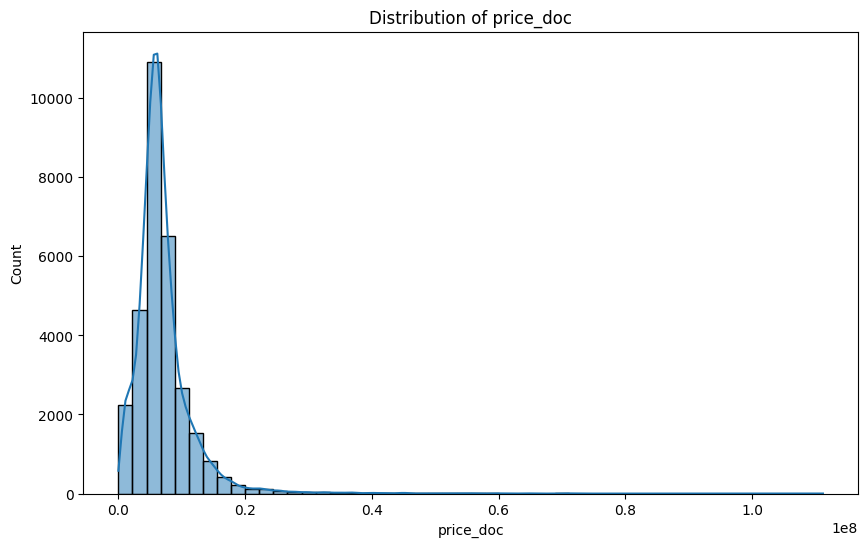

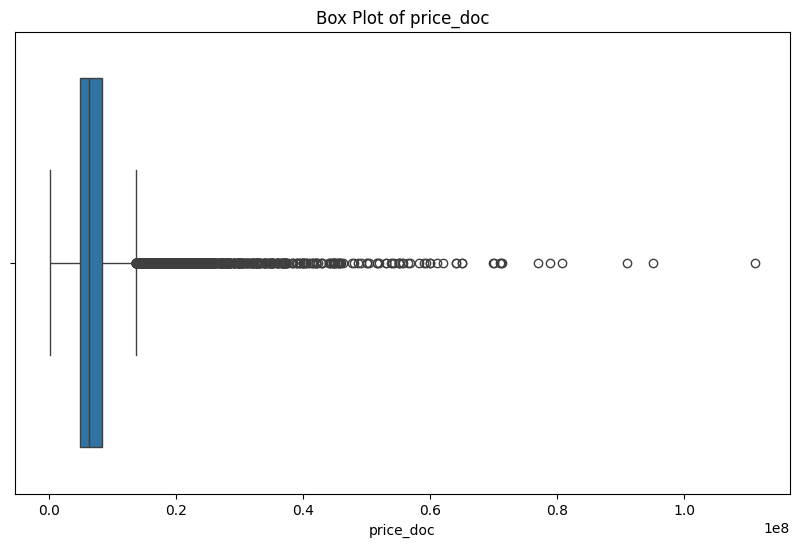

In [24]:
col_to_visualize = 'price_doc'
data_to_visualize = raw_data
data_to_visualize = data_with_outliers_removed
count_values_above_threshold(data_to_visualize, col_name=col_to_visualize)
count_values_below_threshold(data_to_visualize, col_to_visualize, 20)
visualize_target_distribution(data_to_visualize, col_to_visualize)

Outliers detected in 'price_doc':
Count: 10924


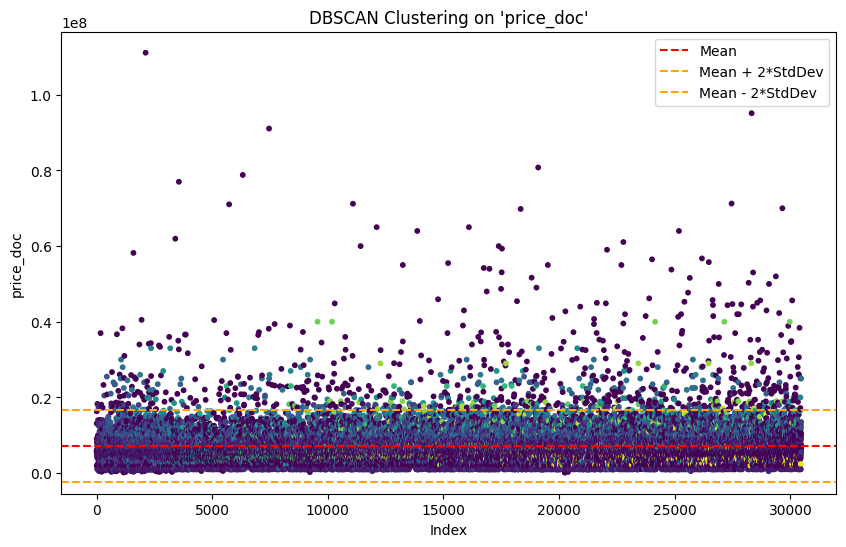

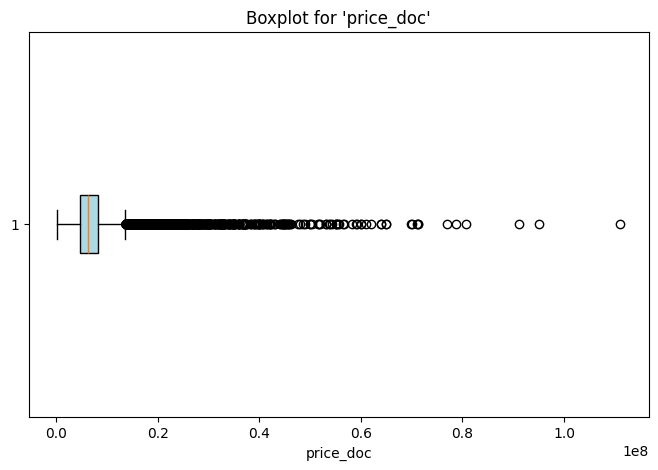

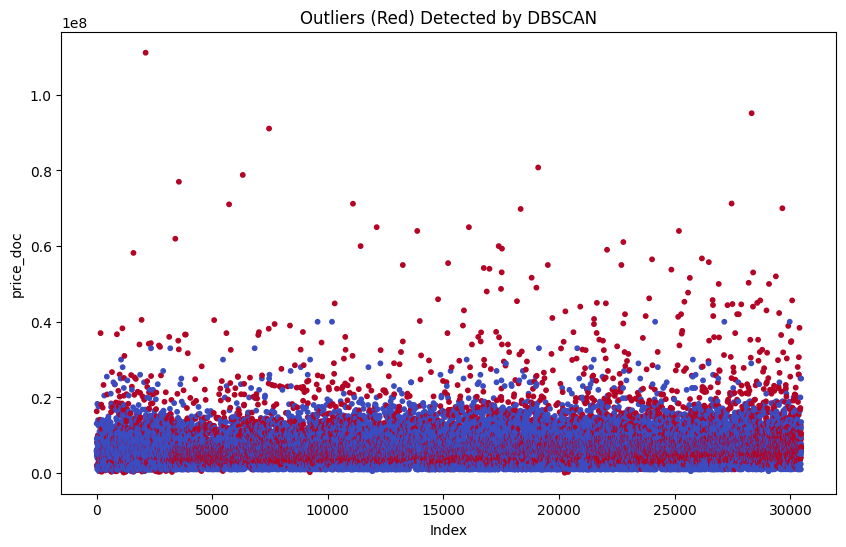

Values (sorted):
[100000, 190000, 200000, 260000, 300000, 301693, 331464, 338570, 340000, 354289, 360000, 395685, 410000, 472249, 476902, 550000, 550637, 551750, 552312, 675205, 700000, 705805, 720000, 779396, 779396, 827400, 897661, 900000, 900000, 900000, 917000, 919584, 950000, 950000, 976000, 989000, 998000, 998000, 998000, 999900, 999990, '1.00m', '1.01m', '1.01m', '1.02m', '1.02m', '1.02m', '1.03m', '1.03m', '1.03m', '1.09m', '1.11m', '1.15m', '1.15m', '1.18m', '1.22m', '1.23m', '1.23m', '1.25m', '1.25m', '1.25m', '1.28m', '1.33m', '1.33m', '1.35m', '1.39m', '1.40m', '1.40m', '1.40m', '1.40m', '1.44m', '1.44m', '1.45m', '1.50m', '1.53m', '1.54m', '1.55m', '1.56m', '1.56m', '1.59m', '1.60m', '1.60m', '1.60m', '1.63m', '1.68m', '1.70m', '1.70m', '1.70m', '1.70m', '1.72m', '1.72m', '1.72m', '1.72m', '1.73m', '1.73m', '1.73m', '1.73m', '1.74m', '1.74m', '1.74m', '1.76m', '1.79m', '1.79m', '1.79m', '1.79m', '1.83m', '1.83m', '1.84m', '1.85m', '1.86m', '1.86m', '1.86m', '1.88m', '1.89m

In [25]:
# Define column for analysis
df = data_with_outliers_removed
col_name = 'price_doc'  # Replace with the column of interest
col_val = df[[col_name]].values  # Keep as original scale

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  # Tune eps for your data's range
labels = dbscan.fit_predict(col_val)

# Add labels to the DataFrame
label_col_name = f'dbscan_label_{col_name}'
df[label_col_name] = labels

# Analyze Outliers
outliers = df[df[label_col_name] == -1]

# Print outlier details
print(f"Outliers detected in '{col_name}':")
print(f"Count: {outliers.shape[0]}")

# Format and sort outlier values
sorted_values = outliers[col_name].sort_values()

def format_values(value):
    if value > 1_000_000:
        return f"{value / 1_000_000:.2f}m"
    return value

formatted_values = [format_values(val) for val in sorted_values]

# Visualize Results
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df[col_name], c=labels, cmap='viridis', s=10)
plt.title(f"DBSCAN Clustering on '{col_name}'")
plt.xlabel("Index")
plt.ylabel(col_name)
plt.axhline(y=col_val.mean(), color='r', linestyle='--', label='Mean')
plt.axhline(y=col_val.mean() + 2 * col_val.std(), color='orange', linestyle='--', label='Mean + 2*StdDev')
plt.axhline(y=col_val.mean() - 2 * col_val.std(), color='orange', linestyle='--', label='Mean - 2*StdDev')
plt.legend()
plt.show()

# Optional: Boxplot for outlier analysis
plt.figure(figsize=(8, 5))
plt.boxplot(df[col_name], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.title(f"Boxplot for '{col_name}'")
plt.xlabel(col_name)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(df.index, df[col_name], c=(df[label_col_name] == -1), cmap='coolwarm', s=10)
plt.title("Outliers (Red) Detected by DBSCAN")
plt.xlabel("Index")
plt.ylabel(col_name)
plt.show()

# Display formatted values
print("Values (sorted):")
print(formatted_values)

In [26]:
# data = Data_train
data = data_with_outliers_removed

X = data.drop(columns=[target_column])
y = data[target_column]

In [27]:
valeraInfo(X)

C:\Users\Nick\AppData\Local\Temp\ipykernel_4168\3045055618.py:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  info = info.style.applymap(color_cells, subset=['Тип данных'])


,Тип данных,Количесвто уникальных,Количество пропусков,Количество значений,%значений
id,int64,30471,0,30471,100.000000
timestamp,datetime64[ns],1161,0,30471,100.000000
full_sq,int64,211,0,30471,100.000000
life_sq,float64,175,6383,24088,79.050000
floor,float64,41,167,30304,99.450000
max_floor,float64,49,9572,20899,68.590000
material,float64,6,9572,20899,68.590000
build_year,float64,119,13605,16866,55.350000
num_room,float64,13,9572,20899,68.590000
kitch_sq,float64,74,9572,20899,68.590000


In [28]:
def get_cols_containing(df, features):
    # Initialize an empty list to store columns
    count_columns = []
    # Iterate over the features to process and collect matching columns
    for feature in features:
        count_columns.extend([col for col in df.columns if feature in col])
    return df[count_columns]

df_cols = get_cols_containing(X, [
'university'
])
df_cols.head(1)


,university_top_20_raion,university_km
0,0,6.715026


In [29]:
def create_accessibility_and_adequacy_features(df):
    df_copy = df.copy()

    # Normalize population data per km² (area in km² already normalized)
    df_copy['population_density'] = df_copy['full_all'] / (df_copy['area_m'] / 1_000_000)

    # Accessibility Features
    df_copy['child_facility_accessibility'] = df_copy['0_6_all'] / (df_copy['kindergarten_km'] + df_copy['preschool_km'] + 1e-6)
    df_copy['school_accessibility'] = df_copy['7_14_all'] / (df_copy['school_km'] + 1e-6)
    df_copy['university_accessibility'] = df_copy['16_29_all'] / (df_copy['university_km'] + 1e-6)
    df_copy['workplace_accessibility'] = df_copy['work_all'] / (df_copy['office_km'] + 1e-6)
    df_copy['elderly_healthcare_accessibility'] = df_copy['ekder_all'] / (df_copy['public_healthcare_km'] + 1e-6)

    # Adequacy Features (Reusing Accessibility)
    df_copy['child_facility_adequacy'] = df_copy['child_facility_accessibility'] / df_copy['population_density']
    df_copy['school_adequacy'] = df_copy['school_accessibility'] / df_copy['population_density']
    df_copy['university_adequacy'] = df_copy['university_accessibility'] / df_copy['population_density']
    df_copy['workplace_adequacy'] = df_copy['workplace_accessibility'] / df_copy['population_density']
    df_copy['elderly_healthcare_adequacy'] = df_copy['elderly_healthcare_accessibility'] / df_copy['population_density']

    # Log-transforming features to reduce skewness
    # for col in [
    #     'child_facility_accessibility', 'school_accessibility', 'university_accessibility',
    #     'workplace_accessibility', 'elderly_healthcare_accessibility',
    #     'child_facility_adequacy', 'school_adequacy', 'university_adequacy',
    #     'workplace_adequacy', 'elderly_healthcare_adequacy'
    # ]:
    #     df_copy[f'log_{col}'] = np.log1p(df_copy[col])

    return df_copy

def clean_up_accessibility_columns(df):
    df_copy = df.copy()

    # List of columns to drop (used for calculations)
    columns_to_drop = [
        'population_density', 'child_facility_accessibility', 'school_accessibility',
        'university_accessibility', 'workplace_accessibility', 'elderly_healthcare_accessibility',
        'child_facility_adequacy', 'school_adequacy', 'university_adequacy',
        'workplace_adequacy', 'elderly_healthcare_adequacy'
    ]
    
    # Drop the columns if they exist in the DataFrame
    df_copy.drop(columns=[col for col in columns_to_drop if col in df_copy.columns], inplace=True, errors='ignore')

    return df_copy

In [30]:
# X = create_accessibility_and_adequacy_features(X)

In [31]:
city_center_features = ['mkad_km', 'ttk_km', 'sadovoe_km', 'bulvar_ring_km', 'kremlin_km', 'area_km']

def create_distance_based_features(df):
    df_copy = df.copy()

    # Convert area to km²
    df_copy['area_km'] = df_copy['area_m'] / 1_000_000

    # Normalize distance features by sub-area size, excluding city center features
    distance_features = [col for col in df.columns if '_km' in col and col not in city_center_features]
    for col in distance_features:
        df_copy[f'relative_{col}'] = df_copy[col] / (df_copy['area_km'] ** 0.5 + 1e-6)

    # Calculate weighted averages for accessibility groups, excluding city center features
    groups = {
        'public_transport_accessibility': ['metro_km_walk', 'metro_km_avto', 'public_transport_station_km'],
        'education_accessibility': ['kindergarten_km', 'school_km', 'university_km', 'preschool_km'],
        'healthcare_accessibility': ['public_healthcare_km', 'hospice_morgue_km'],
        'recreation_accessibility': ['park_km', 'green_zone_km', 'stadium_km', 'fitness_km', 'swim_pool_km'],
        'commerce_accessibility': ['shopping_centers_km', 'market_shop_km', 'big_market_km']
    }
    
    for group_name, group_features in groups.items():
        group_distances = [df_copy[col] for col in group_features if col in df_copy]
        df_copy[group_name] = sum(group_distances) / (len(group_features) + 1e-6)

    # Interaction with population density
    df_copy['population_density'] = df_copy['full_all'] / (df_copy['area_km'] + 1e-6)
    for group_name in groups.keys():
        df_copy[f'{group_name}_per_density'] = df_copy[group_name] / (df_copy['population_density'] + 1e-6)

    # Impact scores for distance features, excluding city center features
    for col in distance_features:
        if col in df_copy.columns:
            df_copy[f'impact_{col}'] = df_copy[col] / (df_copy['full_all'] + 1e-6)

    return df_copy

In [32]:
X = create_distance_based_features(X)

C:\Users\Nick\AppData\Local\Temp\ipykernel_4168\3748206675.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'impact_{col}'] = df_copy[col] / (df_copy['full_all'] + 1e-6)
C:\Users\Nick\AppData\Local\Temp\ipykernel_4168\3748206675.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f'impact_{col}'] = df_copy[col] / (df_copy['full_all'] + 1e-6)
C:\Users\Nick\AppData\Local\Temp\ipykernel_4168\3748206675.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

In [33]:
X['area_km'].head(1)

0   6.407578
Name: area_km, dtype: float64

In [34]:
def process_and_drop_cafe_price_columns(df):
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Define price level weights
    price_weights = {
        '500': 1,
        '1000': 2,
        '1500': 3,
        '2500': 4,
        '4000': 5,
        'high': 6
    }

    # Define distance weights
    distance_weights = {
        '500': 1.5,
        '1000': 1.2,
        '1500': 1.0,
        '2000': 0.8,
        '3000': 0.6,
        '5000': 0.5
    }

    # Extract unique distance ranges from column names
    distance_ranges = sorted(set(col.split('_')[2] for col in df.columns if col.startswith('cafe_count_')), key=int)

    # Process each distance range
    for distance in distance_ranges:
        # Select price-related columns corresponding to the current distance range
        relevant_price_columns = [col for col in df.columns if f'cafe_count_{distance}_price_' in col]

        # Ensure columns are sorted by price level to align with weights
        relevant_price_columns.sort(key=lambda x: list(price_weights.keys()).index(x.split('_')[-1]))

        # Calculate weighted affordability score for this distance range
        df_copy[f'cafe_affordability_{distance}'] = df_copy[relevant_price_columns].dot(
            [price_weights[col.split('_')[-1]] for col in relevant_price_columns]
        )

        # Calculate accessibility score (weighted count) for this distance range
        count_column = f'cafe_count_{distance}'
        weight = distance_weights.get(distance, 1)  # Use provided weight or default to 1 if not specified
        if count_column in df_copy.columns:
            df_copy[f'cafe_accessibility_{distance}'] = df_copy[count_column] * weight

    # Identify all columns to drop
    columns_to_drop = [
        col for col in df_copy.columns
        if (
            # Drop price-related columns
            (col.startswith('cafe_count_') and '_price_' in col)
            # Drop na_price columns
            or (col.endswith('_na_price') and col.startswith('cafe_count_'))
            # Drop min/max/avg price columns
            or any(sub in col for sub in ['_min_price_avg', '_max_price_avg', '_avg_price_'])
            # Drop total count columns per distance
            or any(col == f'cafe_count_{distance}' for distance in distance_ranges)
        )
    ]

    # Drop the identified columns
    df_copy.drop(columns=columns_to_drop, inplace=True)

    # Sort new columns by distance range in ascending order
    sorted_columns = sorted(
        [col for col in df_copy.columns if col.startswith('cafe_affordability_') or col.startswith('cafe_accessibility_')],
        key=lambda x: int(x.split('_')[-1])
    )

    # Reorder columns to place sorted new columns at the end of the DataFrame
    df_copy = df_copy[[col for col in df_copy.columns if col not in sorted_columns] + sorted_columns]

    return df_copy


In [35]:
def aggregate_affordability_accessibility(df):
    df_copy = df.copy()

    # Define weights for each distance range
    distance_weights = {
        '500': 1.5,
        '1000': 1.2,
        '1500': 1.0,
        '2000': 0.8,
        '3000': 0.6,
        '5000': 0.5
    }

    # Identify affordability and accessibility columns
    affordability_columns = [col for col in df.columns if col.startswith('cafe_affordability_')]
    accessibility_columns = [col for col in df.columns if col.startswith('cafe_accessibility_')]

    # Aggregate affordability
    df_copy['cafe_total_affordability'] = df_copy[affordability_columns].dot(
        [distance_weights[col.split('_')[-1]] for col in affordability_columns]
    )

    # Aggregate accessibility
    df_copy['cafe_total_accessibility'] = df_copy[accessibility_columns].dot(
        [distance_weights[col.split('_')[-1]] for col in accessibility_columns]
    )

    # Drop individual distance-specific columns
    df_copy.drop(columns=affordability_columns + accessibility_columns, inplace=True)

    return df_copy


In [36]:
# X = process_and_drop_cafe_price_columns(X)
# X = aggregate_affordability_accessibility(X)

In [37]:
def calculate_incremental_counts(df, base_column):
    df_copy = df.copy()
    distances = sorted(
        [col.split('_')[-1] for col in df.columns if col.startswith(base_column) and col.split('_')[-1].isdigit()],
        key=int
    )

    for i, distance in enumerate(distances):
        current_col = f"{base_column}{distance}"
        if i == 0:
            # First distance, no need to subtract
            df_copy[f"incremental_{current_col}"] = df_copy[current_col]
        else:
            prev_col = f"{base_column}{distances[i - 1]}"
            df_copy[f"incremental_{current_col}"] = df_copy[current_col] - df_copy[prev_col]
    
    return df_copy


In [38]:
def aggregate_weighted_counts(df, base_column, distance_weights):
    # Extract distances from columns and sort them numerically
    distances = sorted(
        [col.split('_')[-1] for col in df.columns if col.startswith(f"incremental_{base_column}")],
        key=int
    )
    
    # Initialize weighted score to 0
    weighted_score = 0
    
    # Accumulate weighted scores for each distance
    for distance in distances:
        col_name = f"incremental_{base_column}{distance}"
        if col_name in df.columns:  # Ensure the column exists in the dataframe
            weighted_score += df[col_name] * distance_weights.get(distance, 1)
    
    return weighted_score


In [39]:
# Drop columns used to calculate sport_count_weighted, but keep sport_count_weighted
def drop_sport_count_columns(df, base_column):
    # Identify columns to drop for incremental counts and base counts
    columns_to_drop = [
        col for col in df.columns 
        if (col.startswith(f"incremental_{base_column}") or col.startswith(base_column))
        and col != f"{base_column}weighted"  # Keep sport_count_weighted
    ]
    
    # Drop the identified columns
    df = df.drop(columns=columns_to_drop, inplace=False)  # inplace=False ensures a new DataFrame is returned
    
    return df

In [40]:
feature_distance_weights = {
    'sport_count_': {'500': 1.49, '1000': 1.26, '1500': 1.35, '2000': 1.29, '3000': 5.00, '5000': 1.41},
    'office_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'trc_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'big_church_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'church_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'mosque_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'leisure_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'market_count_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'trc_sqm_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
    'office_sqm_': {'500': 6, '1000': 5, '1500': 4, '2000': 3, '3000': 2, '5000': 1},
}

# Process and aggregate distance-weighted features
def process_distance_features(X, feature_distance_weights):
    for feature, distance_weights in feature_distance_weights.items():
        # Calculate incremental counts for the current feature
        X = calculate_incremental_counts(X, feature)
        
        # Aggregate the counts into a single weighted score
        X[f'{feature}weighted'] = aggregate_weighted_counts(X, feature, distance_weights)
        
        # Drop the incremental columns for the current feature
        X = drop_sport_count_columns(X, feature)  # Ensure this function handles all *_distance* features

    return X

In [41]:
# X = process_distance_features(X, feature_distance_weights)

In [42]:
def drop_redundant_columns(df, feature_prefix, weight_dict):
    # Generate column names to drop based on the prefix and keys of the weight dictionary
    columns_to_drop = [f"{feature_prefix}_{suffix}" for suffix in weight_dict.keys()]
    # Drop the columns
    return df.drop(columns=columns_to_drop, errors='ignore')

In [43]:
construction_weights = {
    'before_1920': 1,
    '1921-1945': 2,
    '1946-1970': 3,
    '1971-1995': 4,
    'after_1995': 5
}

def calculate_weighted_build_count(df, construction_weights):
    weighted_build_count = sum(
        df[f'build_count_{period}'] * weight
        for period, weight in construction_weights.items()
    )
    return weighted_build_count

In [44]:
# X['weighted_build_count'] = calculate_weighted_build_count(X, construction_weights)
# X = drop_redundant_columns(X, 'build_count', construction_weights)

In [45]:
material_weights = {
    'block': 1.2,
    'wood': 0.5,
    'frame': 1.0,
    'brick': 1.5,
    'monolith': 2.0,
    'panel': 0.8,
    'foam': 0.7,
    'slag': 0.6,
    'mix': 1.1
}

def calculate_weighted_material_score(df, material_weights):
    weighted_score = sum(
        df[f'build_count_{material}'] * weight
        for material, weight in material_weights.items()
    )
    df['weighted_material_score'] = weighted_score
    return df

In [46]:
# X = calculate_weighted_material_score(X, material_weights)
# X = drop_redundant_columns(X, 'build_count', material_weights)

In [47]:
green_weights = {'500': 5, '1000': 4, '1500': 3, '2000': 2, '3000': 1, '5000': 0.5}
prom_weights = {'500': 5, '1000': 4, '1500': 3, '2000': 2, '3000': 1, '5000': 0.5}

def weighted_average_aggregation(X, feature_base_name, distance_weights):
    # Calculate the weighted average
    weighted_column = f"{feature_base_name}_weighted"
    X[weighted_column] = sum(
        X[f"{feature_base_name}_{distance}"] * weight
        for distance, weight in distance_weights.items()
    ) / sum(distance_weights.values())
    
    return X

In [48]:
# X = weighted_average_aggregation(X, 'green_part', green_weights)
# X = weighted_average_aggregation(X, 'prom_part', prom_weights)

# X = drop_redundant_columns(X, 'green_part', green_weights)
# X = drop_redundant_columns(X, 'prom_part', prom_weights)

In [49]:
def get_cols_containing(df, features):
    # Initialize an empty list to store columns
    count_columns = []
    # Iterate over the features to process and collect matching columns
    for feature in features:
        count_columns.extend([col for col in df.columns if feature in col])
    return df[count_columns]

df_cols = get_cols_containing(X, [
'full_all',
'male_f',
'female_f',
'young_all',
'young_male',
'young_female',
'work_all',
'work_male',
'work_female',
'ekder_all',
'ekder_male',
'ekder_female',
'0_6_all',
'0_6_male',
'0_6_female',
'7_14_all',
'7_14_male',
'7_14_female',
'0_17_all',
'0_17_male',
'0_17_female',
'16_29_all',
'16_29_male',
'16_29_female',
'0_13_all',
'0_13_male',
'0_13_female',
])
df_cols.head(1)


,full_all,male_f,female_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female
0,86206,40477,45729,45729,21154,11007,10147,98207,52277,45930,36211,10580,25631,9576,4899,4677,10309,5463,4846,23603,12286,11317,17508,9425,8083,18654,9709,8945


In [50]:
def process_demographic_features(df):
    # Ensure no division by zero
    df['full_all'] = df['full_all'].replace(0, pd.NA)
    
    # Normalize features by total population
    df['male_ratio'] = df['male_f'] / df['full_all']
    df['female_ratio'] = df['female_f'] / df['full_all']
    
    # Gender balance ratio
    df['male_female_ratio'] = df['male_f'] / df['female_f']
    
    # Normalize age groups
    df['young_ratio'] = df['young_all'] / df['full_all']
    df['working_ratio'] = df['work_all'] / df['full_all']
    df['elderly_ratio'] = df['ekder_all'] / df['full_all']
    
    # Aggregate age groups
    df['youth_ratio'] = df['16_29_all'] / df['full_all']
    
    # Dependency ratios
    df['child_dependency_ratio'] = df['young_ratio'] / df['working_ratio']
    df['elderly_dependency_ratio'] = df['elderly_ratio'] / df['working_ratio']
    df['total_dependency_ratio'] = (
        df['young_ratio'] + df['elderly_ratio']
    ) / df['working_ratio']
    
    # Gender ratios for age groups
    df['young_male_ratio'] = df['young_male'] / df['young_all']
    df['work_male_ratio'] = df['work_male'] / df['work_all']
    df['elderly_male_ratio'] = df['ekder_male'] / df['ekder_all']
    
    return df

In [51]:
# X = process_demographic_features(X)

In [52]:
def improve_top_features(df, target):
    df = df.copy()
    
    # Ensure target is aligned with df
    if len(df) != len(target):
        raise ValueError("The length of df and target must be the same.")

    # Add the target as a temporary column to calculate the group mean
    df['target_temp'] = target

    # Sub-area encoding: Compute mean of target and map to sub_area
    sub_area_mean_target = df.groupby('sub_area')['target_temp'].mean()
    df['sub_area_mean'] = df['sub_area'].map(sub_area_mean_target).fillna(0)  # Fill missing values

    # Drop the temporary target column
    df.drop(columns=['target_temp'], inplace=True)

    # Feature interactions
    df['log_full_sq'] = np.log1p(df['full_sq'].clip(lower=0))
    df['full_sq_per_room'] = df['full_sq'] / (df['num_room'] + 1e-6)
    df['avg_room_size'] = df['full_sq'] / (df['num_room'] + 1e-6)
    df['cafe_affordability_per_density'] = df['cafe_total_affordability'] / (df['population_density'] + 1e-6)
    df['num_room_category'] = pd.cut(df['num_room'].fillna(0), bins=[0, 1, 3, 5, np.inf], labels=['Small', 'Medium', 'Large', 'Very Large'])
    df['kremlin_proximity_bin'] = pd.cut(df['kremlin_km'].fillna(np.inf), bins=[0, 2, 5, 10, np.inf], labels=['Very Close', 'Close', 'Moderate', 'Far'])

    # Building age and categories
    current_year = 2024
    df['building_age'] = current_year - df['build_year'].fillna(current_year)
    df['building_age_bin'] = pd.cut(df['building_age'], bins=[0, 10, 30, 100, np.inf], labels=['New', 'Modern', 'Old', 'Historic'])
    df['floor_ratio'] = df['floor'] / (df['max_floor'] + 1e-6)

    # City center proximity
    df['city_center_proximity'] = df[['kremlin_km', 'sadovoe_km', 'ttk_km', 'mkad_km']].mean(axis=1, skipna=True)

    # Building age and state interaction
    df['state_age_interaction'] = df['state'] * df['building_age']

    # Youth ratio normalization
    df['normalized_youth_ratio'] = df['youth_ratio'] / (df['area_m'] / 1_000_000 + 1e-6)

    return df


In [53]:
# X = improve_top_features(X, y)

In [54]:
def drop_initial_population_columns(df):
    columns_to_drop = [
        'male_f', 'female_f',
        'young_all', 'young_male', 'young_female',
        'work_all', 'work_male', 'work_female',
        'ekder_all', 'ekder_male', 'ekder_female',
        '0_6_all', '0_6_male', '0_6_female',
        '7_14_all', '7_14_male', '7_14_female',
        '0_17_all', '0_17_male', '0_17_female',
        '16_29_all', '16_29_male', '16_29_female',
        '0_13_all', '0_13_male', '0_13_female',
        'children_preschool', 'children_school', 'full_all',
    ]
    return df.drop(columns=columns_to_drop, inplace=False)

In [55]:
def drop_institutional_related_columns(df):
    columns_to_drop = [
        'preschool_quota',
        'preschool_education_centers_raion',
        'school_quota',
        'school_education_centers_raion',
        'school_education_centers_top_20_raion',
        'hospital_beds_raion',
        'healthcare_centers_raion',
        'university_top_20_raion',
        'sport_objects_raion',
        'additional_education_raion',
        'culture_objects_top_25_raion',
        'shopping_centers_raion'
    ]
    
    return df.drop(columns=columns_to_drop, errors='ignore')

In [56]:
def drop_initial_km_features(df):
    # Identify columns to drop
    columns_to_drop = [col for col in df.columns if '_km' in col and col not in city_center_features]
    
    # Drop the identified columns
    return df.drop(columns=columns_to_drop, errors='ignore')

In [57]:
def drop_initial_features(df):
    df = drop_initial_population_columns(df)
    df = drop_initial_km_features(df)
    df = drop_institutional_related_columns(df)
    return df

In [58]:
def drop_testing(df):
    columns_to_drop = [
        'mkad_km',
        'ttk_km',
        'sadovoe_km',
        'bulvar_ring_km',
        'area_m'
    ]
    
    return df.drop(columns=columns_to_drop, errors='ignore')

In [59]:
# X = drop_initial_features(X)

In [60]:
# X = create_accessibility_and_adequacy_features(X)

# X = process_and_drop_cafe_price_columns(X)
# X = aggregate_affordability_accessibility(X)

# X = process_distance_features(X, feature_distance_weights)

# X['weighted_build_count'] = calculate_weighted_build_count(X, construction_weights)
# X = drop_redundant_columns(X, 'build_count', construction_weights)
# X = calculate_weighted_material_score(X, material_weights)

# X = drop_redundant_columns(X, 'build_count', material_weights)

# X = weighted_average_aggregation(X, 'green_part', green_weights)
# X = weighted_average_aggregation(X, 'prom_part', prom_weights)

# X = drop_redundant_columns(X, 'green_part', green_weights)
# X = drop_redundant_columns(X, 'prom_part', prom_weights)

# X = process_demographic_features(X)

# # X = improve_top_features(X, y)

# X = drop_initial_features(X)

# X = drop_testing(X)

In [61]:
# X = X.drop(columns=['ekder_male'], inplace=False)    

In [62]:
date_column = 'timestamp'
year_column = 'year_of_transaction'

X = X.copy()
X[date_column] = pd.to_datetime(X[date_column], errors='coerce')
X[year_column] = X[date_column].dt.year
X = X.drop(columns=[date_column])

In [63]:
categorical_columns = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()

print(len(X.columns))
print(len(numerical_columns))
print(len(categorical_columns))

400
385
15


In [64]:
# numeric_cols_with_missing_values = [col for col in numerical_columns if X[col].isna().any()]
# print(len(numeric_cols_with_missing_values))

In [65]:
# Code block
binary_categories_columns = [binary_category_column] + boolean_category_columns
categorical_columns = [ecology_column] + binary_categories_columns + [sub_area_column]
all_columns = categorical_columns + numerical_columns
ecology_index = all_columns.index(ecology_column)

In [66]:
class KNNModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=3):
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        self.knn = NearestNeighbors(n_neighbors=self.n_neighbors)
        self.knn.fit(X[~np.isnan(X).any(axis=1)])
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        col_data = X[:, 0].reshape(-1, 1)
        nan_mask = np.isnan(col_data)
        
        # Ensure there are NaNs to be imputed
        if not nan_mask.any():
            return X
        
        # Find nearest neighbors for rows without NaN values
        distances, neighbors = self.knn.kneighbors(col_data[~nan_mask].reshape(-1, 1))
        
        for i, idx in enumerate(np.where(nan_mask)[0]):
            neighbor_vals = col_data[neighbors[i]].flatten()
            mode_result = mode(neighbor_vals, nan_policy='omit')
            count_value = mode_result.count if np.isscalar(mode_result.count) else mode_result.count[0]
            imputed_value = mode_result.mode if np.isscalar(mode_result.mode) else mode_result.mode[0]
            col_data[idx, 0] = imputed_value
        
        # Ensure column assignment back to X
        X[:, 0] = col_data.flatten()
        
        return X


In [67]:
class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

In [68]:
columns_for_numeric_knn_imputation = [col for col in all_columns if col != ecology_column]

preprocessing_pipeline = Pipeline([
    (
        'encoding',
        ColumnTransformer([
            (
                'ecology_ordinal', 
                OrdinalEncoder(
                    categories=[['poor', 'satisfactory', 'good', 'excellent']], 
                    handle_unknown='use_encoded_value', 
                    unknown_value=np.nan
                ), 
                [ecology_column]
            ),
            (
                'binary_ohe',
                OneHotEncoder(sparse_output=False, drop='if_binary'),
                binary_categories_columns
            ),
            (
                'sub_area_target',
                TargetEncoder(),
                [sub_area_column]
            ),
            (
                'numerical',
                'passthrough',
                numerical_columns
            )
        ])
    ),
    ('scaling', StandardScaler()),
    ('to_dataframe_after_scaling', DataFrameConverter(columns=all_columns)),
    (
        'knn_imputation',
        ColumnTransformer([
            (
                'ecology',
                'passthrough',
                [ecology_column]
            ),
            (
                'knn_imputer',
                KNNImputer(n_neighbors=3),
                columns_for_numeric_knn_imputation
            )
        ])
    ),
    ('to_dataframe_after_knn_imputation', DataFrameConverter(columns=all_columns)),
    (
        'ecology_imputation',
        ColumnTransformer(
            transformers=[(
                'knn_mode_imputer',
                KNNModeImputer(n_neighbors=3),
                [ecology_column]
            )],
            remainder='passthrough'
        )
    )
])

In [69]:
# X_processed = processing_pipeline.fit_transform(X, y)
# X_processed_df = pd.DataFrame(X_processed, columns=all_columns)

In [70]:
# numeric_cols_with_missing_values = [col for col in numerical_columns if X_processed_df[col].isna().any()]
# cols_with_missing_values = [col for col in all_columns if X_processed_df[col].isna().any()]
# print("numeric columns with missing values:", len(numeric_cols_with_missing_values))
# print("all columns with missing values:", len(cols_with_missing_values))
# print("ecology column after imputation:", X_processed_df[ecology_column].unique())

In [71]:
# X_processed = preprocessing_pipeline.fit_transform(X, y)

In [72]:
# processed_pipeline = preprocessing_pipeline.fit(X, y)
# X_scaled = processed_pipeline.transform(X)
X_scaled = undump_ZV('X_scaled_for_DBSCAN_all_features')

In [73]:
X_copy = X.copy()  # Create a copy of the original features
if 'price_doc' not in X.columns:
    X_copy['price_doc'] = y 

# Step 2: Scale the target independently
target_scaler = StandardScaler()
price_doc_scaled = target_scaler.fit_transform(y.values.reshape(-1, 1))

# Combine scaled features and target
X_scaled_combined = np.hstack([X_scaled, price_doc_scaled])

In [74]:
# Step 1: Dimensionality Reduction with PCA
n_components = 50  # Reduce to 50 dimensions
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(X_scaled_combined)  # PCA-transformed dataset

# Step 2: Apply DBSCAN in PCA Space
dbscan = DBSCAN(eps=15, min_samples=60)  # Adjust based on k-distance plot
labels = dbscan.fit_predict(X_reduced)

# Step 3: Map Outliers Back to Original Dataset
outlier_indices = np.where(labels == -1)[0]  # Indices of outliers
outliers_original = X_copy.iloc[outlier_indices]  # Outliers in the original dataset

In [75]:
# Selected top 20 features for analytics
top_20_features = [
    'price_doc', 'full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 
    'kitch_sq', 'state', 'kremlin_km', 'metro_km_walk', 'park_km', 'school_km', 
    'kindergarten_km', 'shopping_centers_km', 'green_zone_km', 'railroad_station_walk_km', 
    'industrial_km', 'cafe_count_500', 'market_count_500'
]

# Analyze Outliers with the Top 20 Features
outliers_top_features = outliers_original[top_20_features]

# Print Outliers Information
print(f"Outliers detected: {len(outlier_indices)}")
print("Sample Outliers in Original Dataset (Top 20 Features):")
outliers_top_features.head()


Outliers detected: 209
Sample Outliers in Original Dataset (Top 20 Features):


,price_doc,full_sq,life_sq,floor,max_floor,build_year,num_room,kitch_sq,state,kremlin_km,metro_km_walk,park_km,school_km,kindergarten_km,shopping_centers_km,green_zone_km,railroad_station_walk_km,industrial_km,cafe_count_500,market_count_500
20,8200000,74,44.000000,10.000000,NaN,NaN,NaN,NaN,NaN,27.174806,5.962910,9.901545,2.500105,0.323308,3.550410,0.190786,3.928728,0.805917,0,0
467,990000,54,32.000000,7.000000,NaN,NaN,NaN,NaN,NaN,27.092381,6.200473,9.835180,2.503890,0.242833,3.498368,0.283015,4.166290,0.729911,0,0
948,17500000,76,45.000000,4.000000,NaN,NaN,NaN,NaN,NaN,1.058690,0.235368,0.714377,0.267419,0.451168,0.204594,0.149878,2.287119,2.294197,118,0
1033,5100000,43,26.000000,5.000000,NaN,NaN,NaN,NaN,NaN,25.254369,6.234457,7.916642,0.332185,0.338039,1.606070,0.542705,1.944540,1.634843,0,0
1153,16758000,49,32.000000,7.000000,NaN,NaN,NaN,NaN,NaN,1.720517,0.907193,0.034232,0.377732,0.232061,0.916297,0.020927,2.170689,1.713154,67,0


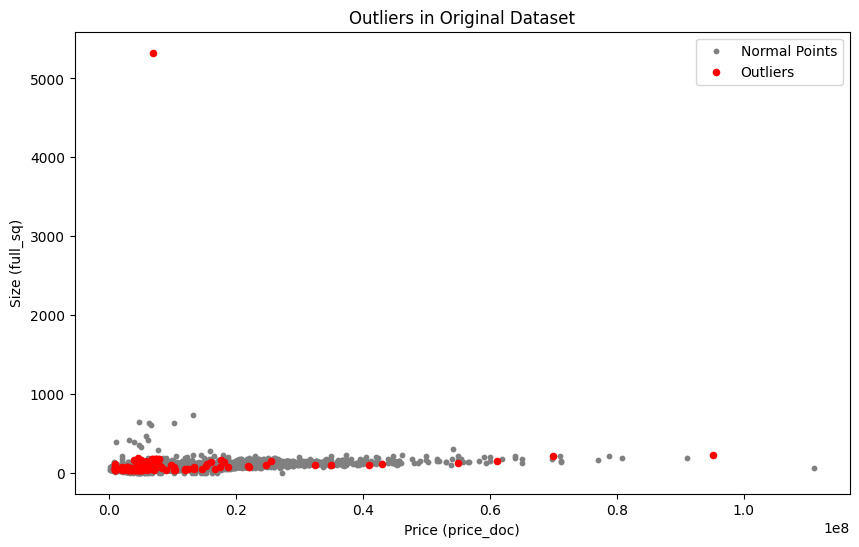

In [76]:
# Step 4: Visualize Outliers in Original Features
plt.figure(figsize=(10, 6))
plt.scatter(X_copy['price_doc'], X_copy['full_sq'], c='gray', s=10, label='Normal Points')
plt.scatter(outliers_original['price_doc'], outliers_original['full_sq'], c='red', s=20, label='Outliers')
plt.title("Outliers in Original Dataset")
plt.xlabel("Price (price_doc)")
plt.ylabel("Size (full_sq)")
plt.legend()
plt.show()

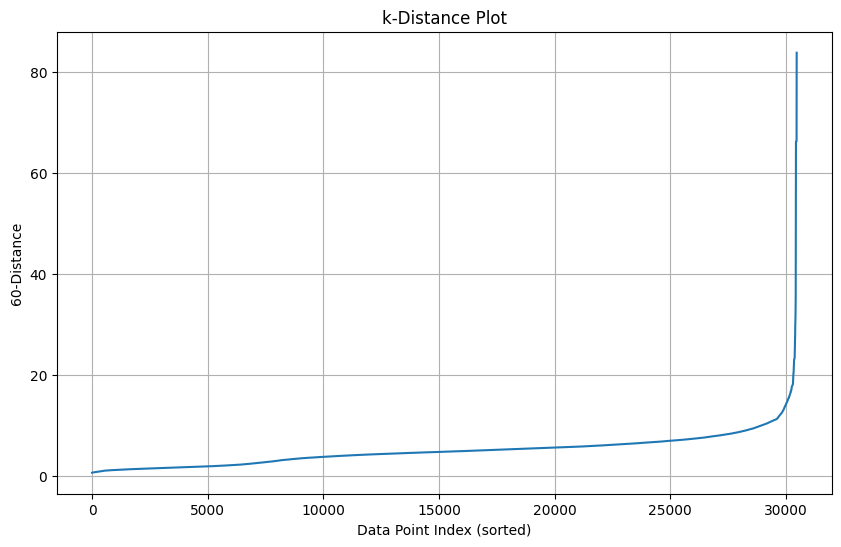

In [77]:
# Step 1: Fit NearestNeighbors on the dataset
k = 60  # min_samples value or a smaller heuristic (e.g., 2 * n_components)
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_reduced)  # Use PCA-reduced dataset
distances, _ = neighbors_fit.kneighbors(X_reduced)

# Step 2: Sort distances for the k-th neighbor
distances = np.sort(distances[:, -1])  # Sort the k-th nearest neighbor distances

# Step 3: Plot the k-Distance Graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title("k-Distance Plot")
plt.xlabel("Data Point Index (sorted)")
plt.ylabel(f"{k}-Distance")
plt.grid()
plt.show()


In [ ]:
raise ValueError("This is a custom error message")

In [ ]:
reduced_features = ['sub_area', 'num_room', 'raion_build_count_with_material_info', 'full_sq', 'elderly_healthcare_accessibility', 'life_sq', 'sport_count_weighted', 'cafe_total_affordability', 'office_sqm_weighted', 'kitch_sq', 'trc_count_weighted', 'cafe_total_accessibility', 'build_year', 'raion_build_count_with_builddate_info', 'product_type']
reduced_features_ordered = [col for col in all_columns if col in reduced_features]

In [ ]:
feature_columns = reduced_features_ordered
feature_columns = all_columns

In [ ]:
# Convert X_processed to a DataFrame if it's in NumPy format
X_processed_df = pd.DataFrame(X_processed, columns=all_columns)  # `all_columns` should be your original list of column names

# Filter the DataFrame to include only the reduced set of features
X_reduced_df = X_processed_df[feature_columns]

# If you need it back as a NumPy array, convert it here
X_reduced = X_reduced_df.to_numpy()

In [ ]:
# X_reduced_df.columns

In [ ]:
# X_split = X_reduced
X_split = X_reduced
print(X_split.shape[1])
print(X_split.shape[0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_split, y, test_size=0.2, random_state=42)

In [ ]:
model = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

In [ ]:
# Cross-validated predictions
cv_predictions = cross_val_predict(model, X_train, y_train, cv=5)

# Calculate cross-validated metrics
cv_mse = mean_squared_error(y_train, cv_predictions)
cv_rmse = np.sqrt(cv_mse)
cv_r2 = r2_score(y_train, cv_predictions)

# Calculate LRMSE for cross-validation
cv_lrmse = np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(cv_predictions)))

print(f"Cross-Validated RMSE: {cv_rmse}")
print(f"Cross-Validated R^2 Score: {cv_r2}")
print(f"Cross-Validated LRMSE: {cv_lrmse}")

# Train the model on the full training data
model.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = model.predict(X_test)

# Calculate test metrics
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, test_predictions)

# Calculate LRMSE for the test set
test_lrmse = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(test_predictions)))

print(f"Test RMSE: {test_rmse}")
print(f"Test R^2 Score: {test_r2}")
print(f"Test LRMSE: {test_lrmse}")

In [ ]:
# Assuming X_test is preprocessed and ready for predictions
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate Mean Squared Logarithmic Error
msle = mean_squared_log_error(y_test, y_pred)

print(f"Mean Squared Logarithmic Error (MSLE): {msle}")

In [ ]:
model_fi = XGBRegressor(
    n_estimators=100,        # Number of trees
    learning_rate=0.1,       # Step size shrinkage used to prevent overfitting
    max_depth=6,             # Maximum tree depth
    subsample=0.8,           # Subsample ratio of the training instances
    colsample_bytree=0.8,    # Subsample ratio of columns for each split
    random_state=42
)

In [ ]:
print(len(X_test))
print(len(y_test))
print(len(X_split))
print(len(y))

In [ ]:
model_fi.fit(X_train, y_train)
importances = model_fi.feature_importances_
len(importances)

In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df.index = range(1, len(feature_importance_df) + 1)
feature_importance_df.index.name = 'Rank'

print(feature_importance_df)

In [ ]:
raise ValueError("This is a custom error message")

In [ ]:
importance_threshold = 0.01
features_all = feature_importance_df['Feature'].tolist()
features_to_keep = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]['Feature'].tolist()
print(len(features_to_keep))
print(len(features_all))

In [ ]:
# Check features that are being kept and dropped based on the threshold
features_below_threshold = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]
features_above_threshold = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]

print("Number of features below threshold:", len(features_below_threshold))
print("Number of features above threshold:", len(features_above_threshold))

# Display the list of features below the threshold to inspect
# print("Features below the threshold of importance:")
# print(features_below_threshold[['Feature', 'Importance']].sort_values(by='Importance', ascending=True))

features_to_keep = features_above_threshold['Feature'].tolist()
print("Features to keep (for hard-coding):")
print(features_to_keep)



# To verify the exact number of features to drop
features_to_drop = features_below_threshold['Feature'].tolist()
print(f"Number of features to drop: {len(features_to_drop)}")
